<a href="https://colab.research.google.com/github/Amiya-1999/Dance-Website/blob/master/Demo02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [68]:

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/TRAIN",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/TRAIN",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 9600 files belonging to 2 classes.
Using 7680 files for training.
Found 9600 files belonging to 2 classes.
Using 1920 files for validation.


In [69]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [70]:
class_names = train_ds.class_names
print(class_names)

['covid', 'normal']


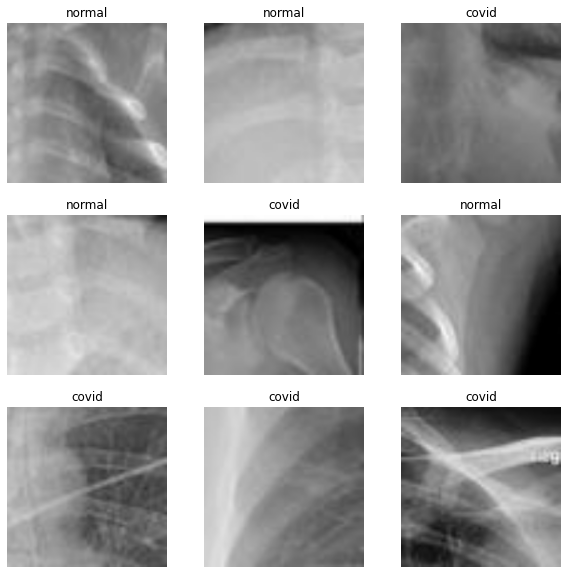

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [72]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

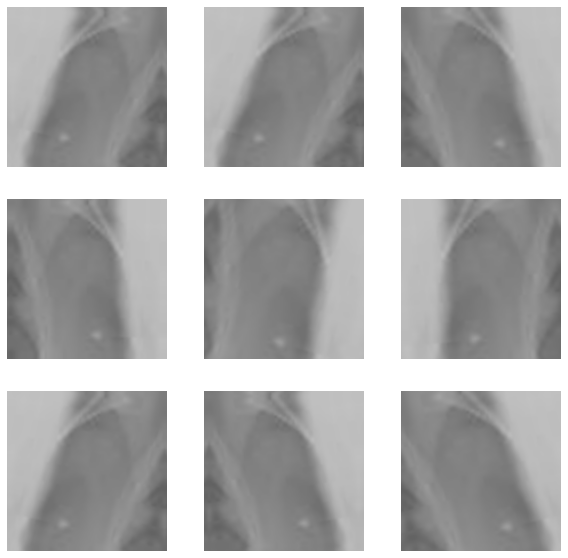

In [73]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [74]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

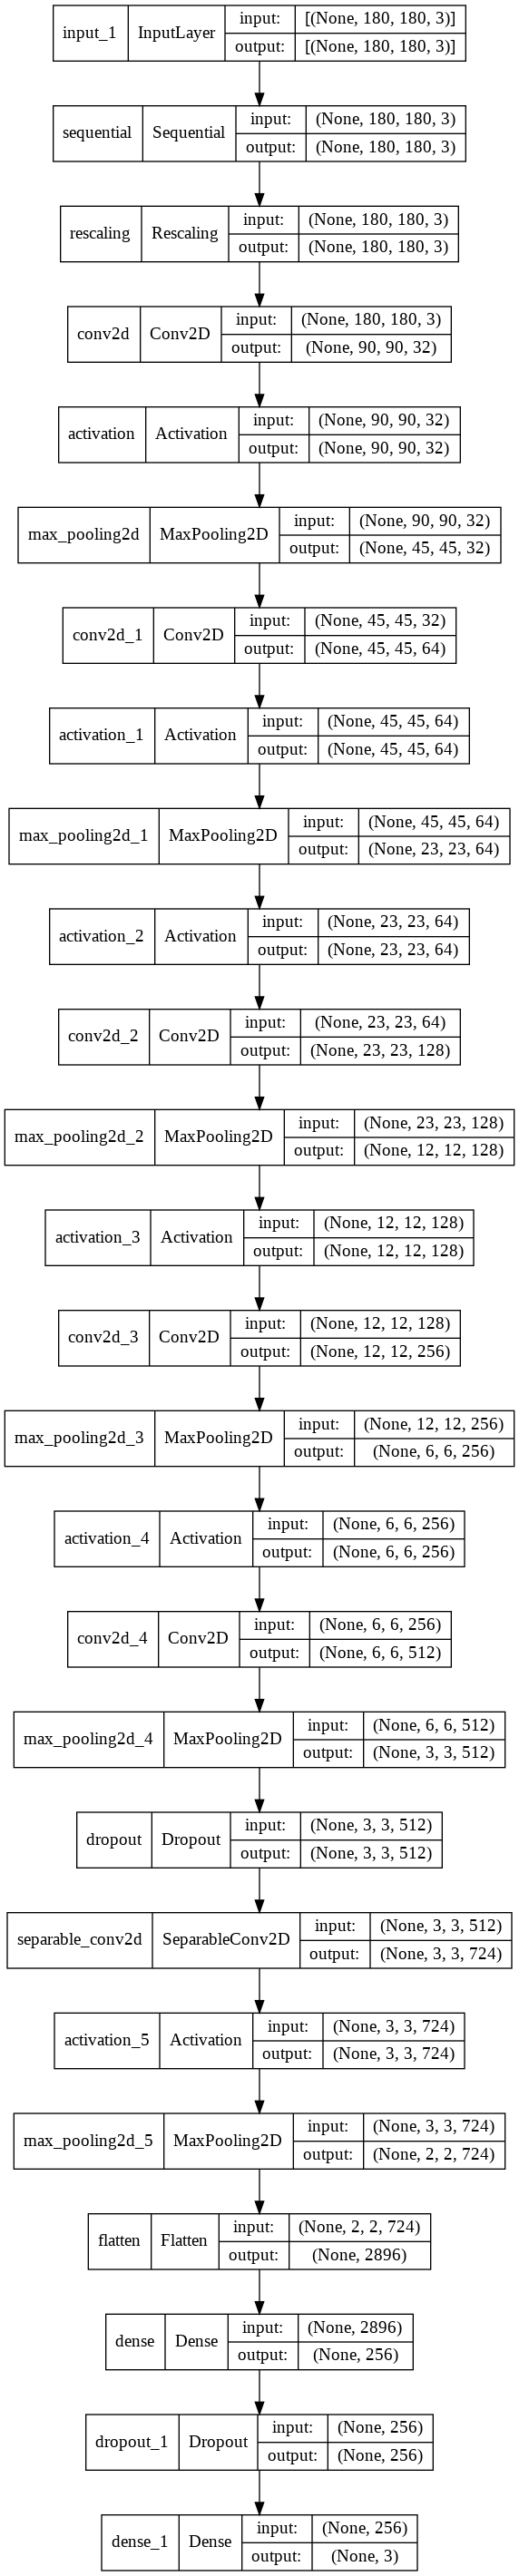

In [81]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)
    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [82]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [83]:
epochs = 50

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [early_stop, lr_callback],
    validation_data = val_ds)

Epoch 1/10
240/240 [==============================] - 669s 2s/step - loss: 0.6924 - accuracy: 0.5471 - val_loss: 0.6065 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 2/10
240/240 [==============================] - 580s 2s/step - loss: 0.6214 - accuracy: 0.6415 - val_loss: 0.6073 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 3/10
240/240 [==============================] - 578s 2s/step - loss: 0.6040 - accuracy: 0.6576 - val_loss: 0.5280 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 4/10
240/240 [==============================] - 580s 2s/step - loss: 0.5016 - accuracy: 0.7504 - val_loss: 0.4245 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 5/10
240/240 [==============================] - 580s 2s/step - loss: 0.4724 - accuracy: 0.7655 - val_loss: 0.4352 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 6/10
240/240 [==============================] - 587s 2s/step - loss: 0.4187 - accuracy: 0.8092 - val_loss: 0.3489 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 7/10
240/240 [==============================] - 584s 2s/st

In [92]:
image_path = "/content/drive/MyDrive/TEST/covid/COVID19(475).jpg"
image_path2 = "/content/drive/MyDrive/TEST/normal/NORMAL(1277).jpg"
image_path3 = '/content/drive/MyDrive/train/COVID19/COVID19(10).jpg'
image_path6 = '/content/drive/MyDrive/TEST/normal/NORMAL(1325).jpg'
merged_path = [image_path,image_path2,image_path3,image_path6]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to covid with a 56.33 percent confidence.
This image most likely belongs to normal with a 40.18 percent confidence.
This image most likely belongs to covid with a 57.59 percent confidence.
This image most likely belongs to normal with a 39.92 percent confidence.


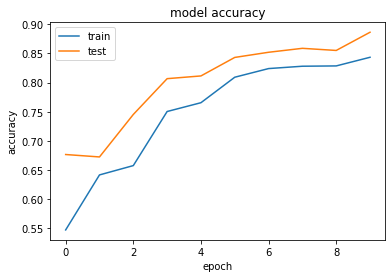

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

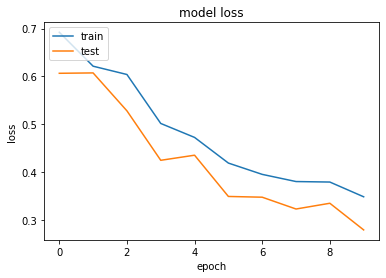

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()